In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
from typing import List, Dict, Optional, Tuple

def plot_model_comparison(
    csv_file: str,
    models: List[str],
    color_list: List[str] = ['#1f77b4', '#ff7f0e'],
    model_name_dict: Optional[Dict[str, List[str]]] = None,
    metric_name: str = 'Score',
    legend_name: str = 'Model Performance',
    title_name: str = 'Raw Model vs Baymin Model Comparison',
    plot_size: Tuple[int, int] = (12, 8),
    show_legend: bool = True,
    separate_bar_names: bool = True,
    show_grid: bool = False
):
    """
    Plot comparison between raw_model and baymin_model scores for specified models.
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file containing the data
    models : List[str]
        List of models to plot (e.g., ['gpt-oss:latest', 'qwen3:8b'])
    color_list : List[str]
        List of two colors for left and right bars (e.g., ['#1f77b4', '#ff7f0e'])
    model_name_dict : Dict[str, List[str]], optional
        Dictionary mapping model names to display names
        e.g., {'gpt-oss:latest': ['GPT-OSS', 'Baymin-GPT-OSS']}
    metric_name : str
        Name for the y-axis (default: 'Score')
    legend_name : str
        Name for the legend (default: 'Model Performance')
    title_name : str
        Title for the plot (default: 'Raw Model vs Baymin Model Comparison')
    plot_size : Tuple[int, int]
        Size of the plot (width, height) in inches (default: (12, 8))
    show_legend : bool
        Whether to show the legend (default: True)
    separate_bar_names : bool
        If True, shows separate names for each bar (e.g., "GPT-OSS" and "Baymin-GPT-OSS")
        If False, shows combined names (e.g., "GPT-OSS\nvs\nBaymin-GPT-OSS") (default: False)
    """
    
    # Read data from CSV using pandas for better column handling
    try:
        df = pd.read_csv(csv_file)
    except pd.errors.ParserError:
        # Fallback to csv reader if pandas fails due to parsing issues
        data = []
        with open(csv_file, 'r') as f:
            reader = csv.reader(f)
            header = next(reader)
            
            for row in reader:
                if len(row) >= 10:  # Ensure we have enough columns
                    model = row[6]  # model column
                    raw_score = float(row[8]) if row[8] else 0  # raw_model_score column
                    baymin_score = float(row[9]) if row[9] else 0  # baymin_score column
                    
                    if model in models:
                        data.append({
                            'model': model,
                            'raw_model_score': raw_score,
                            'baymin_score': baymin_score
                        })
        df = pd.DataFrame(data)
    
    # Filter data for specified models
    df_filtered = df[df['model'].isin(models)]
    
    if df_filtered.empty:
        print("No data found for the specified models.")
        return
    
    # Calculate average scores for each model
    model_stats = df_filtered.groupby('model').agg({
        'raw_model_score': 'mean',
        'baymin_score': 'mean'
    }).reset_index()
    
    # Set up the plot
    plt.figure(figsize=plot_size)
    
    # Set up bar positions
    x = np.arange(len(model_stats))
    width = 0.35
    
    # Create bars
    bars1 = plt.bar(x - width/2, model_stats['raw_model_score'], width, 
                    label='Raw Model', color=color_list[0], alpha=0.8)
    bars2 = plt.bar(x + width/2, model_stats['baymin_score'], width,
                    label='Baymin Model', color=color_list[1], alpha=0.8)
    
    ax = plt.gca()

    pos_raw = x - width/2
    pos_bay = x + width/2

    if model_name_dict:
        raw_labels   = [model_name_dict.get(m, [f"{m} (Raw)", f"{m} (Baymin)"])[0]
                        for m in model_stats['model']]
        baymin_labels = [model_name_dict.get(m, [f"{m} (Raw)", f"{m} (Baymin)"])[1]
                        for m in model_stats['model']]
    else:
        raw_labels   = [f"{m} (Raw)"   for m in model_stats['model']]
        baymin_labels = [f"{m} (Baymin)" for m in model_stats['model']]

    if separate_bar_names:
        # one label per bar (raw, baymin, raw, baymin, ...)
        tick_positions = np.concatenate([pos_raw, pos_bay])
        tick_labels    = raw_labels + baymin_labels
        ax.set_xticks(tick_positions, tick_labels)
    else:
        # one label per group (centered between the two bars)
        group_labels = [
            (f"{model_name_dict[m][0]}\nvs\n{model_name_dict[m][1]}")
            if model_name_dict and m in model_name_dict else m
            for m in model_stats['model']
        ]
        ax.set_xticks(x, group_labels)
    
    # Set labels and title
    plt.xlabel('Models', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.title(title_name, fontsize=14, fontweight='bold')
    
    # Show legend only if show_legend is True
    if show_legend:
        plt.legend(title=legend_name, fontsize=10)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Add grid for better readability
    grid_alpha = 0.3 if show_grid else 0
    plt.grid(show_grid, alpha=grid_alpha, axis='y')
    
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("=" * 50)
    for _, row in model_stats.iterrows():
        model = row['model']
        raw_avg = row['raw_model_score']
        baymin_avg = row['baymin_score']
        improvement = baymin_avg - raw_avg
        
        print(f"Model: {model}")
        print(f"  Raw Model Average: {raw_avg:.3f}")
        print(f"  Baymin Model Average: {baymin_avg:.3f}")
        print(f"  Improvement: {improvement:+.3f}")
        print(f"  Improvement %: {(improvement/raw_avg)*100:+.1f}%" if raw_avg > 0 else "  Improvement %: N/A")
        print("-" * 30)

# Example usage:
# plot_model_comparison(
#     csv_file='test_log.csv',
#     models=['gpt-oss:latest', 'qwen3:8b'],
#     color_list=['#2E8B57', '#FF6347'],
#     model_name_dict={
#         'gpt-oss:latest': ['GPT-OSS', 'Baymin-GPT-OSS'],
#         'qwen3:8b': ['Qwen', 'Baymin-Qwen']
#     },
#     metric_name='Accuracy Score',
#     legend_name='Model Type',
#     title_name='Model Performance Comparison',
#     plot_size=(10, 6),
#     show_legend=True,
#     separate_bar_names=False
# )


/tmp/ipykernel_3818968/4205660711.py:149: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(show_grid, alpha=grid_alpha, axis='y')


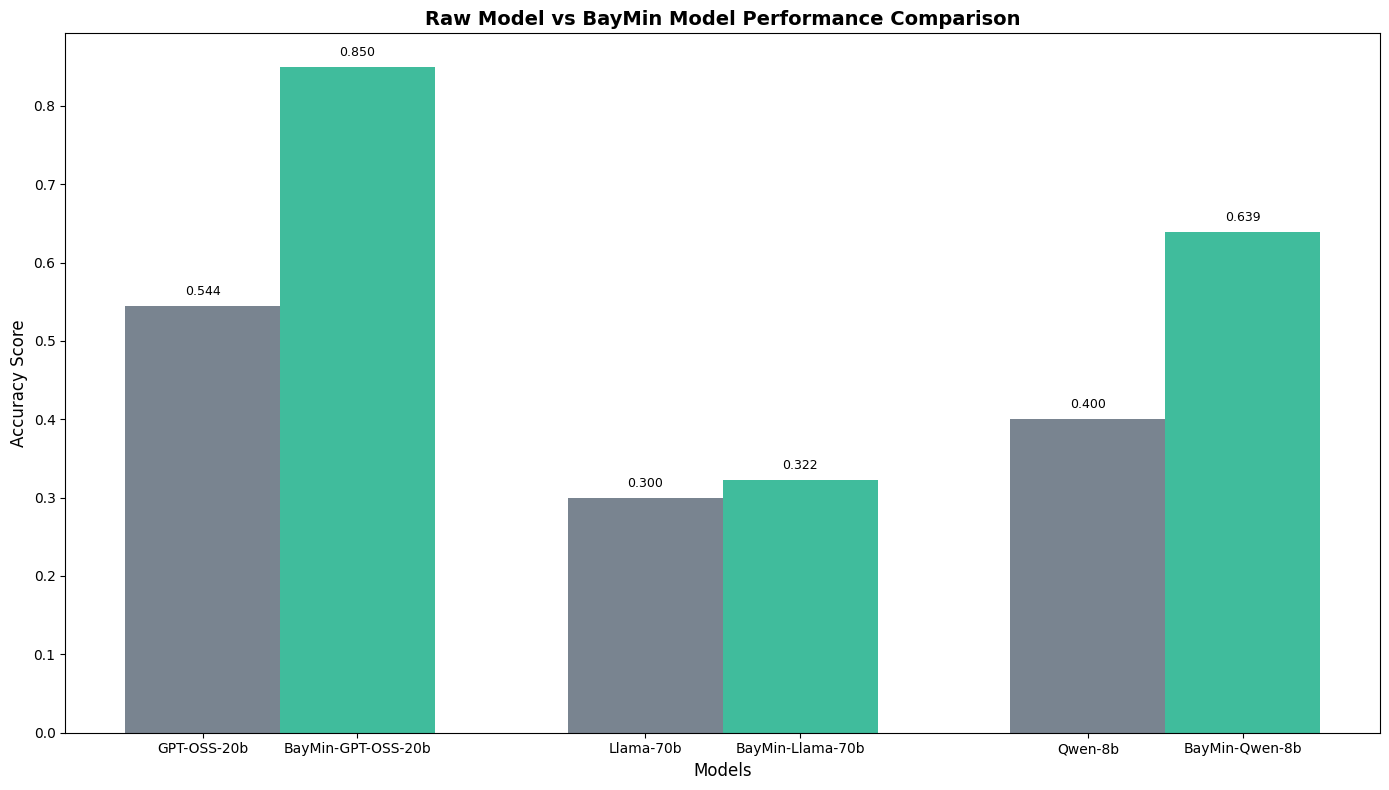


Summary Statistics:
Model: gpt-oss:latest
  Raw Model Average: 0.544
  Baymin Model Average: 0.850
  Improvement: +0.306
  Improvement %: +56.1%
------------------------------
Model: llama3.1:70b
  Raw Model Average: 0.300
  Baymin Model Average: 0.322
  Improvement: +0.022
  Improvement %: +7.4%
------------------------------
Model: qwen3:8b
  Raw Model Average: 0.400
  Baymin Model Average: 0.639
  Improvement: +0.239
  Improvement %: +59.7%
------------------------------


In [8]:
# Example usage of the plot_model_comparison function

# Test with all available models
plot_model_comparison(
    csv_file='test_log.csv',
    models=['gpt-oss:latest', 'qwen3:8b', 'llama3.1:70b'],
    color_list=['#576574', '#10ac84'],  
    model_name_dict={
        'gpt-oss:latest': ['GPT-OSS-20b', 'BayMin-GPT-OSS-20b'],
        'qwen3:8b': ['Qwen-8b', 'BayMin-Qwen-8b'],
        'llama3.1:70b': ['Llama-70b', 'BayMin-Llama-70b']
    },
    metric_name='Accuracy Score',
    show_legend=False,
    title_name='Raw Model vs BayMin Model Performance Comparison',
    plot_size=(14, 8)
)


/tmp/ipykernel_3818968/4205660711.py:149: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(show_grid, alpha=grid_alpha, axis='y')


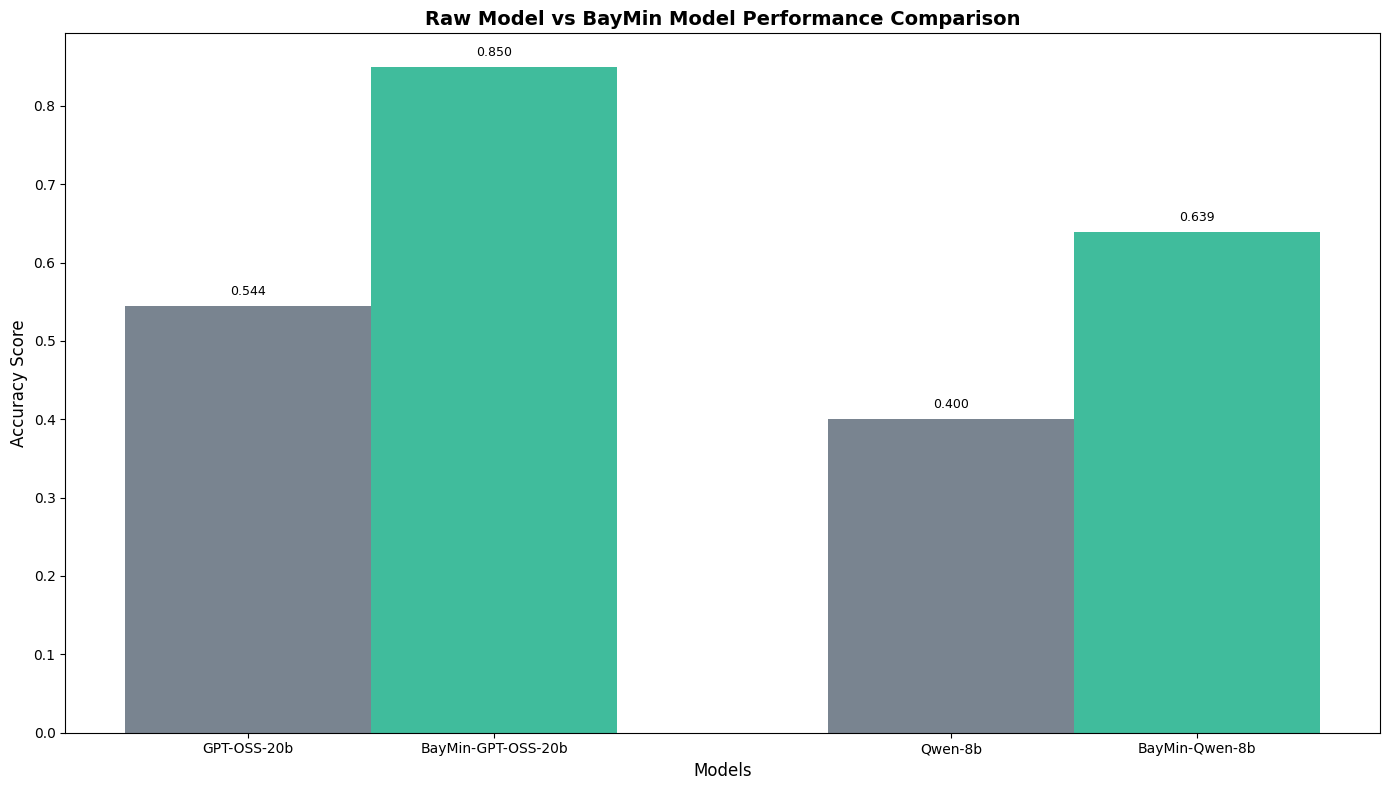


Summary Statistics:
Model: gpt-oss:latest
  Raw Model Average: 0.544
  Baymin Model Average: 0.850
  Improvement: +0.306
  Improvement %: +56.1%
------------------------------
Model: qwen3:8b
  Raw Model Average: 0.400
  Baymin Model Average: 0.639
  Improvement: +0.239
  Improvement %: +59.7%
------------------------------


/tmp/ipykernel_3818968/4205660711.py:149: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(show_grid, alpha=grid_alpha, axis='y')


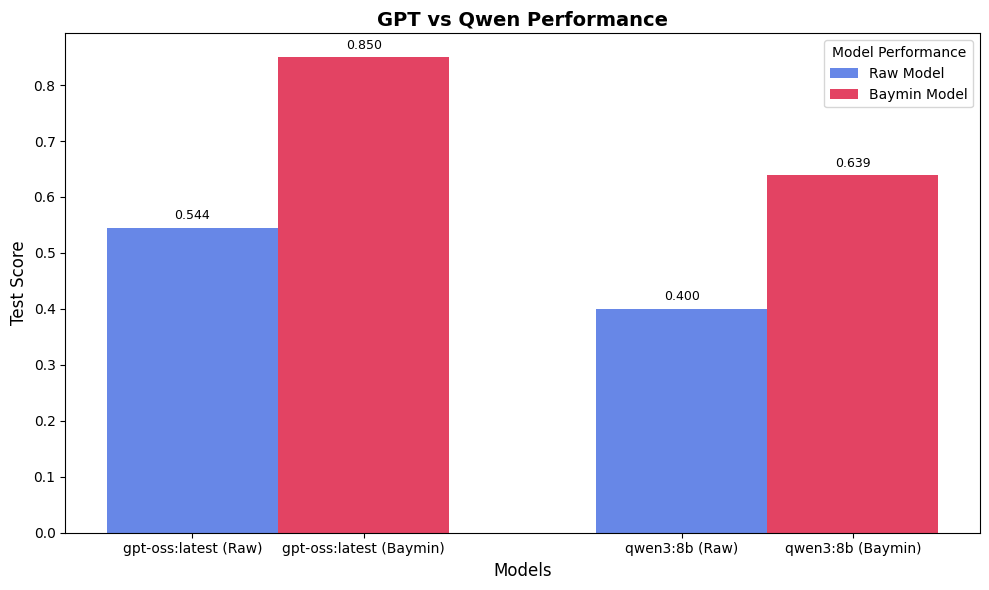


Summary Statistics:
Model: gpt-oss:latest
  Raw Model Average: 0.544
  Baymin Model Average: 0.850
  Improvement: +0.306
  Improvement %: +56.1%
------------------------------
Model: qwen3:8b
  Raw Model Average: 0.400
  Baymin Model Average: 0.639
  Improvement: +0.239
  Improvement %: +59.7%
------------------------------


/tmp/ipykernel_3818968/4205660711.py:149: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(show_grid, alpha=grid_alpha, axis='y')


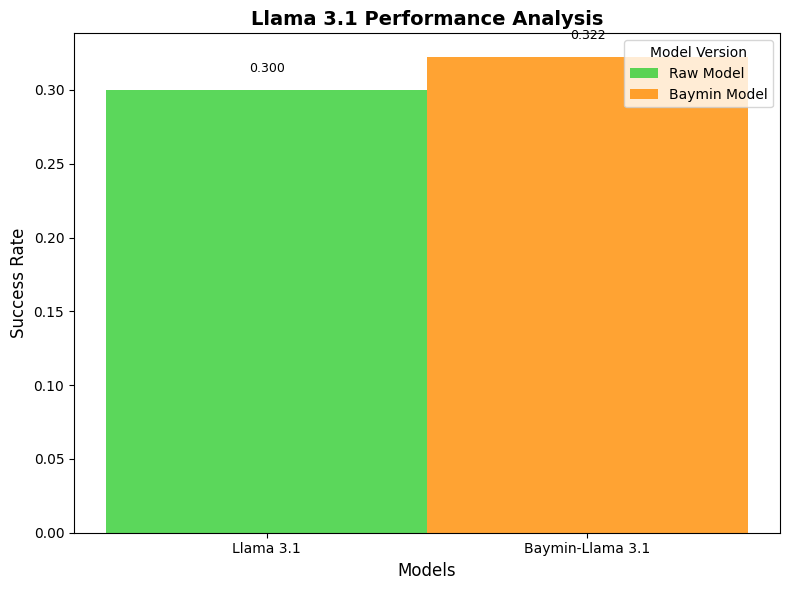


Summary Statistics:
Model: llama3.1:70b
  Raw Model Average: 0.300
  Baymin Model Average: 0.322
  Improvement: +0.022
  Improvement %: +7.4%
------------------------------


In [9]:
# More examples with different customizations

plot_model_comparison(
    csv_file='test_log.csv',
    models=['gpt-oss:latest', 'qwen3:8b'],
    color_list=['#576574', '#10ac84'],  
    model_name_dict={
        'gpt-oss:latest': ['GPT-OSS-20b', 'BayMin-GPT-OSS-20b'],
        'qwen3:8b': ['Qwen-8b', 'BayMin-Qwen-8b'],
        # 'llama3.1:70b': ['Llama-70b', 'BayMin-Llama-70b']
    },
    metric_name='Accuracy Score',
    show_legend=False,
    title_name='Raw Model vs BayMin Model Performance Comparison',
    plot_size=(14, 8)
)

# Example 1: Just two models with custom colors
plot_model_comparison(
    csv_file='test_log.csv',
    models=['gpt-oss:latest', 'qwen3:8b'],
    color_list=['#4169E1', '#DC143C'],  # Royal Blue and Crimson
    metric_name='Test Score',
    title_name='GPT vs Qwen Performance',
    plot_size=(10, 6)
)

# Example 2: Single model with different styling
plot_model_comparison(
    csv_file='test_log.csv',
    models=['llama3.1:70b'],
    color_list=['#32CD32', '#FF8C00'],  # Lime Green and Dark Orange
    model_name_dict={
        'llama3.1:70b': ['Llama 3.1', 'Baymin-Llama 3.1']
    },
    metric_name='Success Rate',
    legend_name='Model Version',
    title_name='Llama 3.1 Performance Analysis',
    plot_size=(8, 6)
)


/tmp/ipykernel_3772138/2687191001.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(show_grid, alpha=0.3, axis='y')


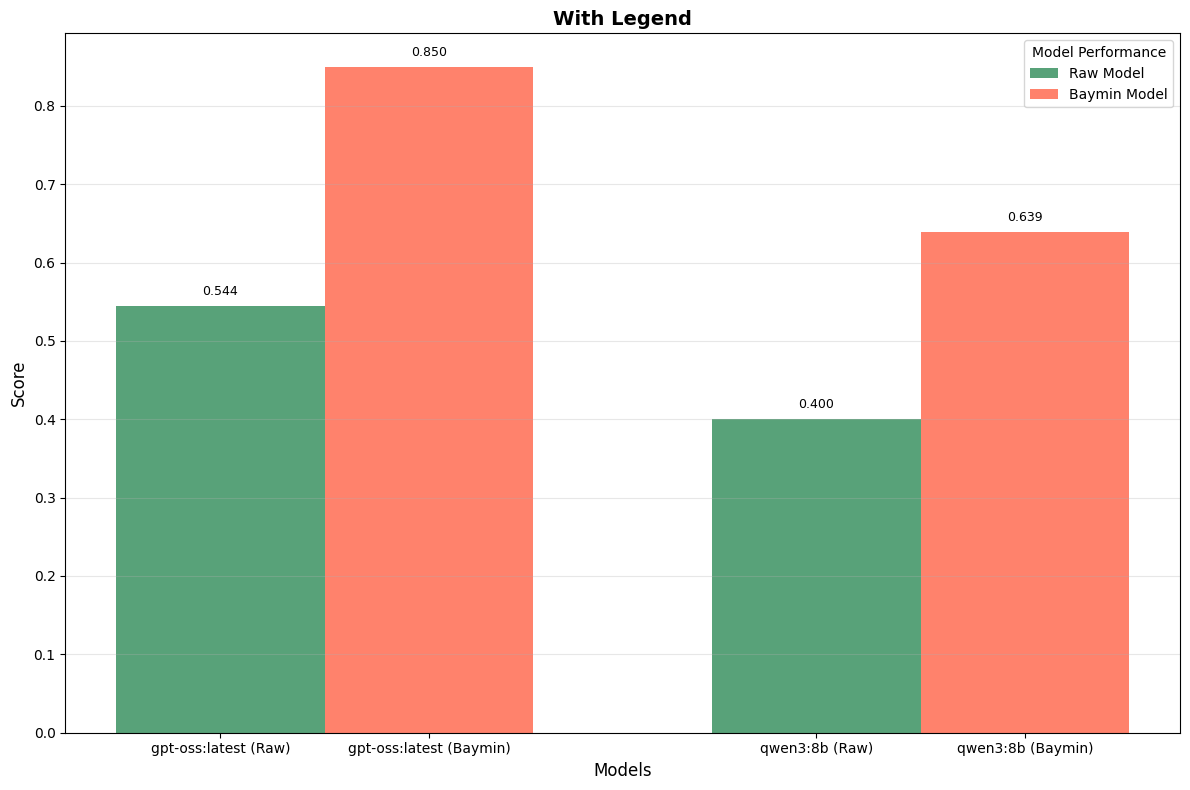

/tmp/ipykernel_3772138/2687191001.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(show_grid, alpha=0.3, axis='y')



Summary Statistics:
Model: gpt-oss:latest
  Raw Model Average: 0.544
  Baymin Model Average: 0.850
  Improvement: +0.306
  Improvement %: +56.1%
------------------------------
Model: qwen3:8b
  Raw Model Average: 0.400
  Baymin Model Average: 0.639
  Improvement: +0.239
  Improvement %: +59.7%
------------------------------


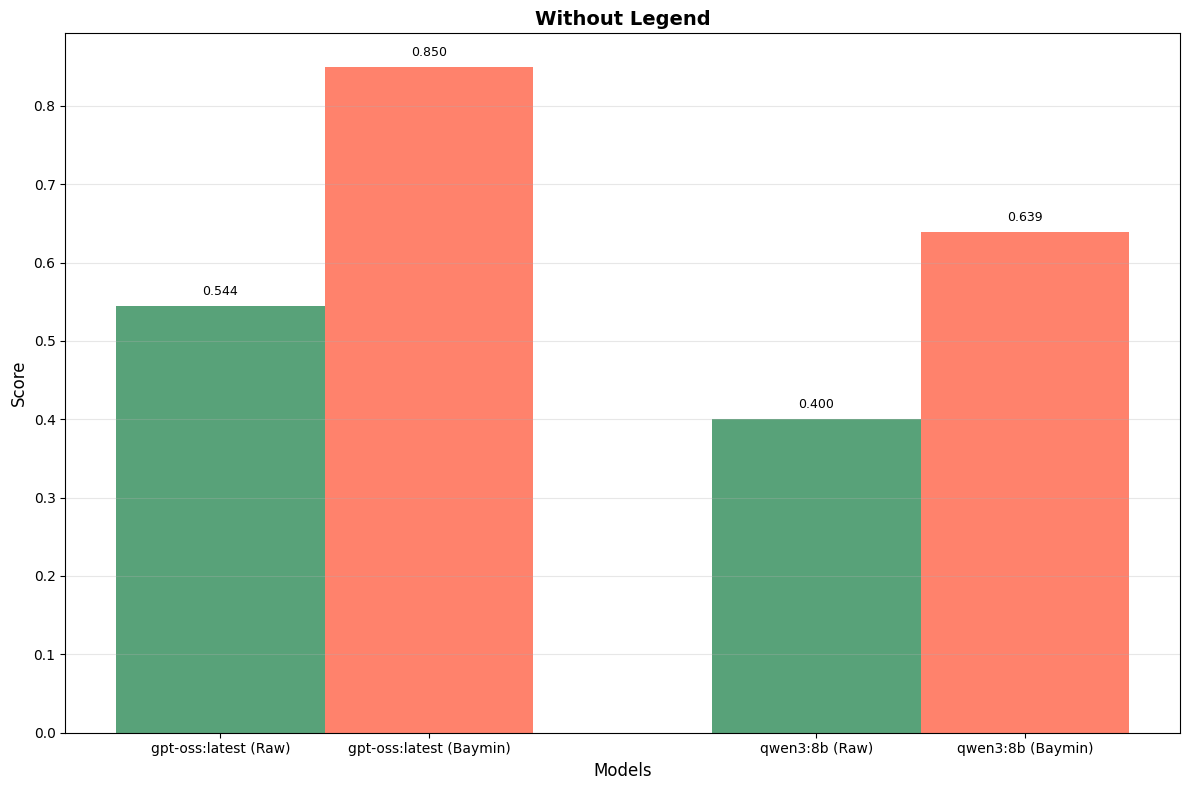


Summary Statistics:
Model: gpt-oss:latest
  Raw Model Average: 0.544
  Baymin Model Average: 0.850
  Improvement: +0.306
  Improvement %: +56.1%
------------------------------
Model: qwen3:8b
  Raw Model Average: 0.400
  Baymin Model Average: 0.639
  Improvement: +0.239
  Improvement %: +59.7%
------------------------------


In [53]:
# Example demonstrating the show_legend parameter

# With legend (default)
plot_model_comparison(
    csv_file='test_log.csv',
    models=['gpt-oss:latest', 'qwen3:8b'],
    color_list=['#2E8B57', '#FF6347'],
    title_name='With Legend',
    show_legend=True
)

# Without legend
plot_model_comparison(
    csv_file='test_log.csv',
    models=['gpt-oss:latest', 'qwen3:8b'],
    color_list=['#2E8B57', '#FF6347'],
    title_name='Without Legend',
    show_legend=False
)


/tmp/ipykernel_3772138/2687191001.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(show_grid, alpha=0.3, axis='y')


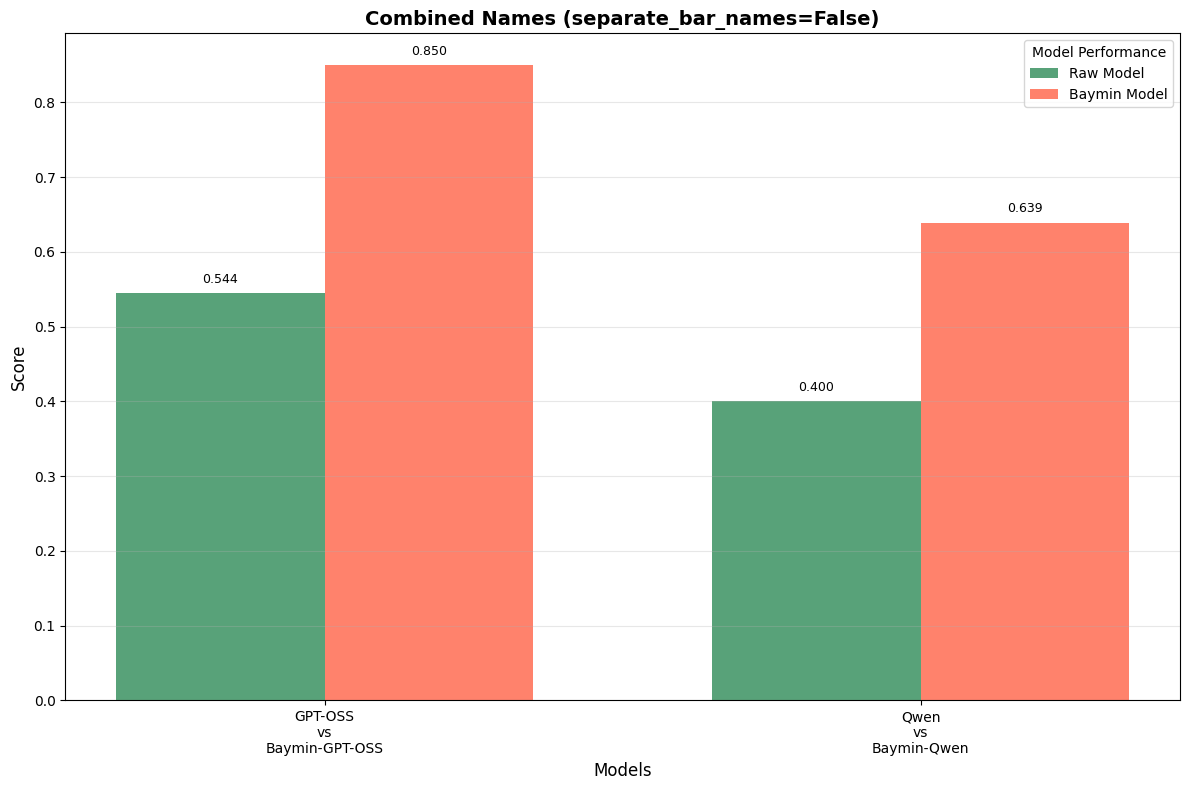


Summary Statistics:
Model: gpt-oss:latest
  Raw Model Average: 0.544
  Baymin Model Average: 0.850
  Improvement: +0.306
  Improvement %: +56.1%
------------------------------
Model: qwen3:8b
  Raw Model Average: 0.400
  Baymin Model Average: 0.639
  Improvement: +0.239
  Improvement %: +59.7%
------------------------------


/tmp/ipykernel_3772138/2687191001.py:148: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(show_grid, alpha=0.3, axis='y')


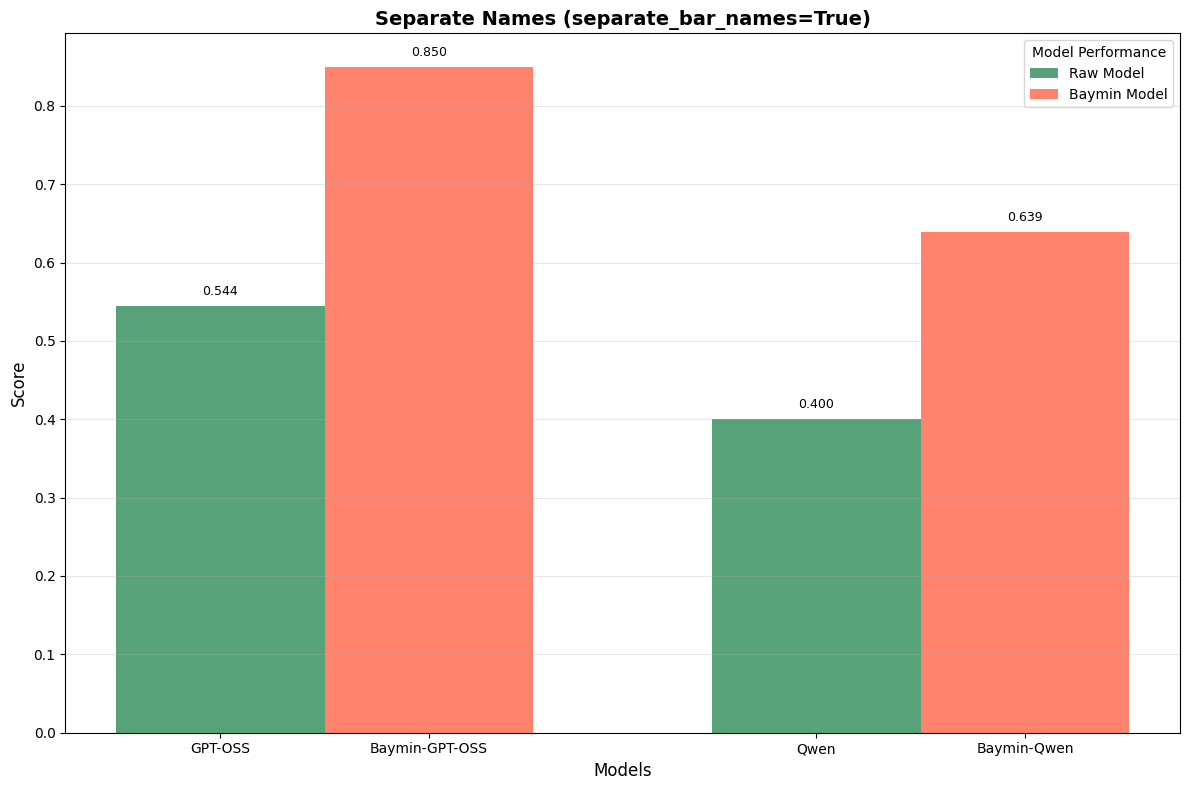


Summary Statistics:
Model: gpt-oss:latest
  Raw Model Average: 0.544
  Baymin Model Average: 0.850
  Improvement: +0.306
  Improvement %: +56.1%
------------------------------
Model: qwen3:8b
  Raw Model Average: 0.400
  Baymin Model Average: 0.639
  Improvement: +0.239
  Improvement %: +59.7%
------------------------------


In [54]:
# Example demonstrating the separate_bar_names parameter

# Combined names (original behavior) - separate_bar_names=False
plot_model_comparison(
    csv_file='test_log.csv',
    models=['gpt-oss:latest', 'qwen3:8b'],
    color_list=['#2E8B57', '#FF6347'],
    model_name_dict={
        'gpt-oss:latest': ['GPT-OSS', 'Baymin-GPT-OSS'],
        'qwen3:8b': ['Qwen', 'Baymin-Qwen']
    },
    title_name='Combined Names (separate_bar_names=False)',
    separate_bar_names=False
)

# Separate names for each bar - separate_bar_names=True
plot_model_comparison(
    csv_file='test_log.csv',
    models=['gpt-oss:latest', 'qwen3:8b'],
    color_list=['#2E8B57', '#FF6347'],
    model_name_dict={
        'gpt-oss:latest': ['GPT-OSS', 'Baymin-GPT-OSS'],
        'qwen3:8b': ['Qwen', 'Baymin-Qwen']
    },
    title_name='Separate Names (separate_bar_names=True)',
    separate_bar_names=True
)
